In [1]:
import plotly.express as px

import pandas as pd
import numpy as np
import os, sys, pickle, warnings, functools, pathlib, json
from tqdm import tqdm
from matplotlib import pyplot as plt

from pathos.threading import ThreadPool
import editdistance
import multiprocess

sys.path.append('../scripts/')
from attention_extractor import get_attention_weights, TCRModel, Explain_TCRModel
from analysis_util import get_mat_from_result_tuple

# Ignite
from analysis_util import get_mat_from_result_tuple
from ignite.engine import Events, create_supervised_trainer
from ignite.handlers import Checkpoint

sys.path.append('../')
sys.path.append('../..')

from recipes.dataset import MCPASDataset

import torch

In [2]:
def remove_UNK_and_take_subset(df_train):
    df_nounk = df_train[df_train['tcra']!='UNK']
    print("df_nounk.value_counts() \n\t ", df_nounk.sign.value_counts().to_dict())
    print("df_nounk.drop_duplicates('tcrb') \n\t ", df_nounk.drop_duplicates('tcrb').sign.value_counts().to_dict())
    return df_nounk

@functools.lru_cache()
def get_df(datapath):
    return pd.DataFrame(pickle.load(open(datapath, "rb"))).assign(datapath=datapath)

def get_df_from_path(p_list):
    return pd.concat([get_df(d) for d in p_list]).reset_index(drop=True)

def split_and_get_first(a):
    if ',' in a:
        a = a.split(',')[0]
    return a



def func_multithread(
        xs,
        func,
        n_threads=os.cpu_count()-1
):
    pool = ThreadPool(nodes=n_threads)
    params = xs #[(x, y) for x in xs for y in ys]
    result = pool.map(lambda p: func(p), params)
    return result

# Recover model

In [3]:
MAXLENGTH_A, MAXLENGTH_B, max_len_epitope = 28, 28, 25

KFOLD_I = 3

def get_file_paths(bucket, dirname, feat_name, extension='.parquet'):
    import boto3
    dataroot = f"s3://{bucket}/"
    objs = boto3.resource("s3").Bucket(f"{bucket}").objects.filter(
        Prefix=f"{dirname}/{feat_name}")
    files = [obj.key for obj in objs
             if not obj.key.startswith(f"{dirname}.ipynb_checkpoints") and obj.key.endswith(extension)]
    files = [os.path.join(dataroot, f) for f in files]
    return files


FNAME ='../scripts/dir_kicker/logs/files_20220212_200237_alldata.csv'
INTERGER_SELECTOR = 1
logdf = pd.read_csv(FNAME)
dt = logdf.checkp[INTERGER_SELECTOR].split('/')[-1]

print('dt', dt)

CHECKPOINT_DIR = f's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/{dt}'
OUT_DIR = '../../../tcr_attention_cachedir'

PATH = f"./fakedata_v0.parquet"  # This is for torch.Dataset

KFOLD_I = logdf.knum[INTERGER_SELECTOR].item()
print('KFOLD_I', KFOLD_I)

REPLACE_TUPLE = ('~/jupyter_notebook/user_work/tcrpred/scripts/../../hhyylog/', '../../../hhyylog/')
checkpoint_files = get_file_paths('sg-playground-kkoyama-temp', 'tcrpred/checkpoint', '', '.pt')
checkpoint_files_withdt = [f for f in checkpoint_files if f'_{dt}_' in f]

CHECKPOINT_PATH = checkpoint_files_withdt[0].split('/')[-1]

# os.system(f'''aws s3 sync {CHECKPOINT_DIR}/ ./../../../checkpoint/{dt}/''')
# os.system(f'''aws s3 sync s3://sg-playground-kkoyama-temp/tcrpred/hhyylog/{dt}_results_attention_tra.pickle ./../../hhyylog/''')


device = 'cpu'

with open(f"../hpo_params/optuna_best.json", "r") as fp:
    hparams = json.load(fp)

# fix random seeds
seed = 9
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# parameters
with open(f'../hpo_params/optuna_best.json', 'r') as fp:
    hparams = json.load(fp)

d_model, d_ff, n_head,n_local_encoder,n_global_encoder = hparams['d_model'], hparams['d_ff'], hparams['n_head'], hparams['n_local_encoder'], hparams['n_global_encoder']
dropout=hparams['dropout']
early_stopping_target = "pr_auc_on_one"
batch_size = hparams['batch_size']
lr=hparams['lr']

n_tok = 29  # NUM_VOCAB
n_pos1 = 62  # MAX_LEN_AB (sum of maxlens of a and b)
n_pos2 = 26  # MAX_LEN_Epitope
n_seg = 3

'''Model, optim, trainer'''
model = TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                 n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                 n_tok=n_tok, n_pos1=n_pos1,
                n_pos2=n_pos2, n_seg=n_seg,)

explain_model = Explain_TCRModel(d_model=d_model, d_ff=d_ff, n_head=n_head, n_local_encoder=n_local_encoder, 
                                 n_global_encoder=n_global_encoder, dropout=dropout, scope=4, 
                                 n_tok=n_tok, n_pos1=n_pos1, n_pos2=n_pos2, n_seg=n_seg)
explain_model.load_state_dict(model.state_dict(), strict=False)

model.to(device)
explain_model = explain_model.to(device)

model = model.eval()
explain_model = explain_model.eval()


# Optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr)

# Loss
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 15.0], device=device))

trainer = create_supervised_trainer(
    model=model, optimizer=optim, loss_fn=loss_fn, device=device,
)

checkpoint_files = get_file_paths('sg-playground-kkoyama-temp', 'tcrpred/checkpoint', '', '.pt')
checkpoint_files_withdt = [f for f in checkpoint_files if dt in f]
CHECKPOINT_DIR = f's3://sg-playground-kkoyama-temp/tcrpred/checkpoint/{dt}'
CHECKPOINT_PATH = checkpoint_files_withdt[0].split('/')[-1]

## Get the prediction and the best model
to_load = {'model': model, 'optimizer': optim, 'trainer': trainer}
torch_check_point_local = '../../../checkpoint/'
fro = os.path.join(CHECKPOINT_DIR, CHECKPOINT_PATH)
if not os.path.exists(os.path.join(torch_check_point_local, CHECKPOINT_PATH)):
    os.system(f'''aws s3 cp {fro} {torch_check_point_local}''')
    
checkpoint = torch.load(os.path.join(torch_check_point_local, CHECKPOINT_PATH), map_location=torch.device(device))
checkpoint['trainer']['seed'] = 9

Checkpoint.load_objects(to_load=to_load, checkpoint=checkpoint)


dt 20220211_191954
KFOLD_I 3


# Data

In [4]:
TCELLTYPE_MAP = {'MHCI':'CD8', 'MHCII':'CD4', 'CD4,CD8':'CD8', 'CD8':'CD8', 'CD4':'CD4'}

RCOLS = ['tcra', 'tcrb', 't_cell','peptide', 'data_type', 'tcra:tcrb', 'sign']

p_list = [
    f"../.././external_data/ERGO-II/Samples/vdjdb_train_samples.pickle",
    f"../.././external_data/ERGO-II/Samples/mcpas_train_samples.pickle", 
    "../.././external_data/ERGO-II/Samples/vdjdb_test_samples.pickle",
    "../.././external_data/ERGO-II/Samples/mcpas_test_samples.pickle",
         ]

df_ergo = get_df_from_path(p_list)
df_ergo = remove_UNK_and_take_subset(df_ergo)
df_ergo['tcra:tcrb'] = df_ergo['tcra'] + ':' + df_ergo['tcrb']

df_ergo['data_type'] = df_ergo.datapath.str.split('/').apply(lambda x: x[-1])

print("df_ergo.shape with no t-cell-type", df_ergo.shape, end=' -> ')
df_ergo = df_ergo.dropna(subset=['t_cell_type'])
df_ergo['t_cell'] = df_ergo['t_cell_type'].map(TCELLTYPE_MAP)
print(df_ergo.shape, )

jem_20211327_tables3 = pd.read_csv('../data/jem_20211327_tables3.csv')
for c in ['CDR3.alpha', 'CDR3.beta', ]:
    jem_20211327_tables3 = jem_20211327_tables3.dropna(subset=[c])
jem_20211327_tables3['tcra:tcrb'] = jem_20211327_tables3['CDR3.alpha'] + ':' + jem_20211327_tables3['CDR3.beta']

jem_20211327_tables3 = jem_20211327_tables3.rename(columns={'CDR3.alpha':'tcra','CDR3.beta':'tcrb'})

jem_20211327_tables3['data_type'] = 'jem_20211327_tables3'

jem_20211327_tables3['t_cell'] = 'CD4'
jem_20211327_tables3['sign'] = np.nan
jem_20211327_tables3['peptide'] = np.nan

## df_all 
df_all = pd.concat([jem_20211327_tables3[RCOLS], df_ergo[RCOLS]])

print("df_all.shape", df_all.shape)

df_nounk.value_counts() 
	  {0: 146088, 1: 29123}
df_nounk.drop_duplicates('tcrb') 
	  {0: 15387, 1: 3775}
df_ergo.shape with no t-cell-type (175211, 14) -> (169015, 15)
df_all.shape (170811, 7)


In [5]:
df_all.loc[df_all['tcra:tcrb'].duplicated()]

print("df_all.shape with no duplicates", df_all.shape, end=' -> ')
df_all = df_all[~df_all['tcra:tcrb'].duplicated()] #.data_type.value_counts()

print("", df_all.shape, )


print("df_all.shape with sampled", df_all.shape, end=' -> ')

df_all = pd.concat(
    [df_all[df_all['data_type']=='vdjdb_train_samples.pickle'], # .sample(frac=0.6, random_state=0),
     df_all[df_all['data_type']!='vdjdb_train_samples.pickle']
    ])

print("", df_all.shape, )

df_all.shape with no duplicates (170811, 7) ->  (24088, 7)
df_all.shape with sampled (24088, 7) ->  (24088, 7)


In [6]:
# df_all.to_parquet('s3://sg-playground-kkoyama-temp/tcrpred/vdjdb_seq_samples.parquet')

In [7]:
DICT_DIS = {}

def calcdis(s1,s2):
    if (s1,s2) in DICT_DIS:
        return DICT_DIS[(s1,s2)]
    else:
        d = editdistance.eval(s1, s2)
        DICT_DIS[(s1, s2)] = d
        DICT_DIS[(s2, s1)] = d
        return d

def to_distance_map(seqs):
    ret = {}
    for s in seqs:
        func = functools.partial(calcdis, s2=s)
#         with multiprocess.Pool(os.cpu_count()-1) as p:
#             dict_list = p.map(func, seqs)
        dict_list = func_multithread(seqs, func)
        ret[s] = dict_list
    return ret


def to_distance_map_single(seqs):
    ret = {}
    for s in tqdm(seqs):
        func = functools.partial(calcdis, s2=s)
        dict_list = [func(s) for s in seqs]
        ret[s] = dict_list
    return ret

In [8]:
df_all['tcraXtcrb'] = df_all['tcra'] + 'P'*100 + df_all['tcrb']

In [9]:
"""# !rm tcr_all_distmat.txt tcr_all_aligned.txt tcr_all_fasta.txt """

'# !rm tcr_all_distmat.txt tcr_all_aligned.txt tcr_all_fasta.txt '

In [10]:
%%time

ofile = open("tcr_p100_fasta.txt", "w")
for i, seq in enumerate(df_all.tcraXtcrb.tolist()):
    ofile.write(">" + str(i) + "\n" + seq + "\n")
ofile.close()


if not os.path.exists('tcr_p100_aligned.txt'):
    os.system("~/Downloads/clustalo -i tcr_p100_fasta.txt -o tcr_p100_aligned.txt --full --distmat-out=tcr_p100_distmat.txt")


CPU times: user 19.6 ms, sys: 5.52 ms, total: 25.2 ms
Wall time: 30.6 ms


In [11]:
%%time

import multiprocess as mp
if not os.path.exists('tcr_p100_distmat.parquet'):
    pd_reader = pd.read_csv('tcr_p100_distmat.txt',sep=' 0', skiprows=[0], header=None, 
                                  chunksize=1000
                                 ) #.tail(2)

    with mp.Pool(os.cpu_count()-1) as p:
        df_list = p.map(lambda x:x, pd_reader)
        
        
    df_distmat = pd.concat(df_list)
    df_distmat = df_distmat.iloc[:,1:]
    df_distmat.columns = df_distmat.columns.astype(str)
    df_distmat.to_parquet('tcr_p100_distmat.parquet')
else:
    df_distmat = pd.read_parquet('tcr_p100_distmat.parquet')
    

CPU times: user 8.62 s, sys: 21.5 s, total: 30.2 s
Wall time: 10.2 s


In [56]:
top10_pep = df_all.peptide.value_counts().head(3000000000).index

<Axes: >

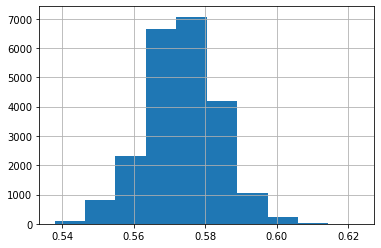

In [57]:
%%time

df_all.reset_index(drop=True, inplace=True)

pepKLGGALQAK = df_all[df_all.peptide.isin(top10_pep)]

pep_distmat = df_distmat.loc[pepKLGGALQAK.index]
pep_distmat.index = pepKLGGALQAK['tcra:tcrb'].values

pep_distmat.columns = df_all['tcra:tcrb'].values
pep_distmat = pep_distmat.replace(0.0, 100.00)

display(pep_distmat.min(axis=1).hist())

# Close pairs for mutation

In [58]:
close_pairs = pep_distmat.idxmin(axis=1)
close_pairs = close_pairs.to_frame().reset_index().rename(columns={'index':0, 0:1})

In [59]:
data0 = pd.merge(close_pairs[[0]], 
         df_all[['tcra:tcrb','peptide', 'sign']],
         left_on=[0],
         right_on=['tcra:tcrb'],
         suffixes=('_0','_0')
        ).drop(columns=['tcra:tcrb']).rename(columns={'peptide':'peptide_0', 'sign':'sign_0'})

data1 = pd.merge(close_pairs[[1]], 
         df_all[['tcra:tcrb','peptide', 'sign']],
         left_on=[1],
         right_on=['tcra:tcrb'],
         suffixes=('_1','_1')
        ).drop(columns=['tcra:tcrb']).rename(columns={'peptide':'peptide_1', 'sign':'sign_1'})

data01 = pd.concat([data0, data1, ], axis=1)

data01 = data01[(data01.peptide_0==data01.peptide_1) &
       (data01.sign_0!=data01.sign_1)
      ]

alphabeta = pd.concat([data01[0].str.split(':').apply(pd.Series).rename(columns={0:'tcra0',1:'tcrb0'}),
           data01[1].str.split(':').apply(pd.Series).rename(columns={0:'tcra1',1:'tcrb1'})
          ], axis=1)

data01 = pd.concat([data01, alphabeta], axis=1)

data01['alpha_samelen'] = data01.tcra0.apply(len) == data01.tcra1.apply(len)
data01['beta_samelen'] = data01.tcrb0.apply(len) == data01.tcrb1.apply(len)

In [60]:
data01 = data01[data01.beta_samelen & data01.alpha_samelen]

In [75]:
def t_series_to_TF(t_series):
    beta_list, alpha_list = [], []
    now_alpha = True

    for i in t_series.index:
        if ':' in i:
            now_alpha = False
            continue

        if now_alpha:
            alpha_list.append('T' if t_series.loc[i] else 'F')
        else:
            beta_list.append('T' if t_series.loc[i] else 'F')
    return ''.join(alpha_list), ''.join(beta_list)

def get_attended(alpha, beta, pep, ONLY_HEAD_ZERO=True):
    df = pd.DataFrame({'sign':1, 'tcra':alpha,'tcrb':beta, 'peptide':pep}, index=[0])
    
    torch_dataset = MCPASDataset(df)
    analysis_loader = torch.utils.data.DataLoader(torch_dataset)

    with torch.no_grad():
        for i, (xx,yy) in enumerate(analysis_loader):
            result_tuple = get_attention_weights([x.to(device) for x in xx], 
                                           model, explain_model=explain_model, device=device)

    # result_tuple[0].shape, result_tuple[1].shape, result_tuple[2]
    # print('prediction =', result_tuple[2])
    attention_pep4_tcr4 = get_mat_from_result_tuple(result_tuple, alpha,beta,pep)
    
    if ONLY_HEAD_ZERO == True:
        attention_tcr4 = [(attention_pep4_tcr4[1][i] > 4.5 * attention_pep4_tcr4[1][i].std())
                          for i in range(1)]
        attention_pep4 = [(attention_pep4_tcr4[0][i] > 5.5 * attention_pep4_tcr4[0][i].std())
                      for i in range(1)]
    else:
        attention_tcr4 = [(attention_pep4_tcr4[1][i] > 4.5 * attention_pep4_tcr4[1][i].std())
                          for i in range(4)]
        attention_pep4 = [(attention_pep4_tcr4[0][i] > 5.5 * attention_pep4_tcr4[0][i].std())
                      for i in range(4)]

    attended_tcrs = pd.concat(attention_tcr4).any()
    attended_peps = pd.concat(attention_pep4).any()
    alpha_tf, beta_tf = t_series_to_TF(attended_tcrs)
    return alpha_tf, beta_tf, "".join(['T' if p else 'F' for p in attended_peps.values]), result_tuple[2]



In [100]:
data01_attention0 = pd.DataFrame([get_attended(r['tcra0'], r['tcrb0'], r['peptide_0']) for i, r in data01.iterrows()])

datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CILAYSGAGSYQLTF, bseq=CASSQSLYGYEQYF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CVVNILNTGGFKTIF, bseq=CASSEVGLSYEQYF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAESGYNQGGKLIF, bseq=CASSEAYMNTGELFF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAVSANYAQGLTF, bseq=CASSGQDSAETLYF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAVSRGQAGTALIF, bseq=CAWSLAGGEQFF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAMTRSGYSTLTF, bseq=CASSPDAGNTIYF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAVPNQAGTALIF, bseq=CASSDWDSSYEQYF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAVDSSNTGKLIF, bseq=CASTNPGTTLHF, peptide=KLGGALQAK
datasize and y

In [101]:
data01_attention1 = pd.DataFrame([get_attended(r['tcra1'], r['tcrb1'], r['peptide_1']) for i, r in data01.iterrows()])

datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAARMIYNQGGKLIF, bseq=CSAIIVGQYYGYTF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAMREDDTNAYKVIF, bseq=CASSLRGDNQAPLF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CALSEAGNNNDMRF, bseq=CASSQGGRINQPQHF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAMSLYNFNKFYF, bseq=CASGTSTNIYEQYF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAYRSVFGNEKLTF, bseq=CASTQGLAEQFF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAVGPLNDYKLSF, bseq=CATSSTGLKTQYF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAVRNSGNTPLVF, bseq=CAISESWGGAEAFF, peptide=KLGGALQAK
datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CALRETSGSRLTF, bseq=CASRPLAGELFF, peptide=KLGGALQAK
datasize and y

In [103]:
data01_attention0.columns = ['attention_alpha0', 'attention_beta0', 'attention_peptide0', 'prediction0']

In [104]:
data01_attention1.columns = ['attention_alpha1', 'attention_beta1', 'attention_peptide1', 'prediction1']

In [110]:
pd.set_option('display.max_columns', 500)


In [112]:
pd.concat([data01.reset_index(), data01_attention0, data01_attention1], axis=1).to_csv('/Users/kyoheikoyama/Downloads/attention_result.csv')

In [95]:
r

(1090,
 0                CILAYSGAGSYQLTF:CASSQSLYGYEQYF
 peptide_0                             KLGGALQAK
 sign_0                                      0.0
 1                CAARMIYNQGGKLIF:CSAIIVGQYYGYTF
 peptide_1                             KLGGALQAK
 sign_1                                      1.0
 tcra0                           CILAYSGAGSYQLTF
 tcrb0                            CASSQSLYGYEQYF
 tcra1                           CAARMIYNQGGKLIF
 tcrb1                            CSAIIVGQYYGYTF
 alpha_samelen                              True
 beta_samelen                               True
 Name: 1090, dtype: object)

In [90]:
a, b, p, pred = get_attended('CAGRSDGQKLLF', 'CASSPTGQGYNEQFF', 'KLGGALQAK')

datasize and y-vcounts:  (1, 4) 1    1
Name: sign, dtype: int64
aseq=CAGRSDGQKLLF, bseq=CASSPTGQGYNEQFF, peptide=KLGGALQAK


In [91]:
a, b, p, pred

('TTTFFFFFFFFF', 'FFFFFFFFFFFFFFF', 'FFFFFFFFF', 0.9196252226829529)

In [77]:
t_series_to_TF(t)

('TTTFFFFFFFFF', 'FFFFFFFFFFFFFFF')

In [73]:
beta_list

['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F']

In [29]:
df_all

,tcra,tcrb,t_cell,peptide,data_type,tcra:tcrb,sign,tcraXtcrb
0,CAVENYGQNFVF,CASSYDSPTEAFF,CD8,GPGHKARVL,vdjdb_train_samples.pickle,CAVENYGQNFVF:CASSYDSPTEAFF,0.0,CAVENYGQNFVFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
1,CAAGGSGGYQKVTF,CASSLADRNTEAFF,CD8,AVFDRKSDAK,vdjdb_train_samples.pickle,CAAGGSGGYQKVTF:CASSLADRNTEAFF,0.0,CAAGGSGGYQKVTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
2,CALSELGGATNKLIF,CASSLVGLPSSYNSPLHF,CD8,ELAGIGILTV,vdjdb_train_samples.pickle,CALSELGGATNKLIF:CASSLVGLPSSYNSPLHF,0.0,CALSELGGATNKLIFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
3,CAASHTNTGNQFYF,CASSSPGKSSYNEQFF,CD8,KLGGALQAK,vdjdb_train_samples.pickle,CAASHTNTGNQFYF:CASSSPGKSSYNEQFF,1.0,CAASHTNTGNQFYFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
4,CLVGDGTGTASKLTF,CASSWGVGSTEAFF,CD8,KLGGALQAK,vdjdb_train_samples.pickle,CLVGDGTGTASKLTF:CASSWGVGSTEAFF,0.0,CLVGDGTGTASKLTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
...,...,...,...,...,...,...,...,...
24083,CAGSGGYQKVTF,CPSPLVGGGRF,CD4,LPRRSGAAGA,mcpas_test_samples.pickle,CAGSGGYQKVTF:CPSPLVGGGRF,0.0,CAGSGGYQKVTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
24084,CAASGGSNYKLTF,CAWGVLFIGRGVGDYGYTF,CD8,GILGFVFTL,mcpas_test_samples.pickle,CAASGGSNYKLTF:CAWGVLFIGRGVGDYGYTF,1.0,CAASGGSNYKLTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
24085,CALGELSSGGYQKVTF,CASSSLGQGAPEAF,CD8,RYPLTFGWCF,mcpas_test_samples.pickle,CALGELSSGGYQKVTF:CASSSLGQGAPEAF,1.0,CALGELSSGGYQKVTFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...
24086,CAAGITF,CASSFRDRGNYAEQF,CD8,SYIPSAEKI,mcpas_test_samples.pickle,CAAGITF:CASSFRDRGNYAEQF,1.0,CAAGITFPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP...


In [13]:
import umap
reducer = umap.UMAP(metric='precomputed', random_state=42)
embedding = reducer.fit_transform(df_distmat)
print('embedding.shape', embedding.shape)


df_emb = pd.DataFrame(embedding, columns=['umap0','umap1'])
df_emb['tcraXtcrb'] = df_all.tcraXtcrb.tolist()

df_emb = pd.merge(df_emb, df_all, on=['tcraXtcrb'], how='left')

/Users/kyoheikoyama/.pyenv/versions/miniconda3-latest/envs/tcrpred/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


embedding.shape (24088, 2)


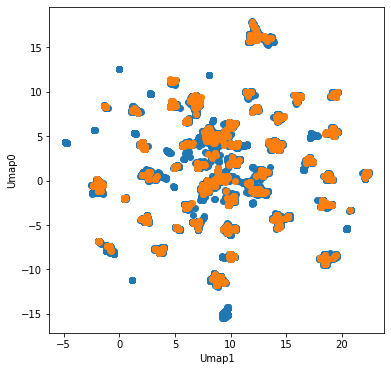

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(df_emb.query('data_type!="jem_20211327_tables3"').umap0, 
            df_emb.query('data_type!="jem_20211327_tables3"').umap1)
plt.scatter(df_emb.query('data_type=="jem_20211327_tables3"').umap0, 
            df_emb.query('data_type=="jem_20211327_tables3"').umap1)
# plt.title('Pep')
plt.xlabel('Umap1')
plt.ylabel('Umap0')
plt.show()

In [16]:

# fig = px.scatter(df_emb, x="umap0", y="umap1",
#                  color='data_type', symbol='t_cell', opacity=0.51,
# #                  hover_name="country", hover_data=["continent", "pop"]
#                  title='TCR distribution'
#                 )

# fig.show()


In [17]:

# fig = px.scatter(df_emb.sample(600), x="umap0", y="umap1",
#                  color='data_type', symbol='t_cell', opacity=0.51,
# #                  hover_name="country", hover_data=["continent", "pop"]
#                  title='TCR distribution (600 TCRs sampled)'
#                 )

# fig.show()


In [18]:

# fig = px.scatter(df_emb, x="umap0", y="umap1",
#                  color='t_cell', 
#                  opacity=0.51,
#                 )

# fig.show()

In [20]:

# fig = px.scatter(df_emb, x="umap0", y="umap1",
# #                  color='data_type', 
#                  color='data_type', 
#                  opacity=0.51,
                 
# #                  hover_name="country", hover_data=["continent", "pop"]
#                 )

# fig.show()


In [21]:
df_all[df_all.data_type!='jem_20211327_tables3'].sign.value_counts() / ((df_all.data_type!='jem_20211327_tables3').sum())


0.0    0.800375
1.0    0.199625
Name: sign, dtype: float64

In [20]:
# temp = df_emb.dropna(subset=['sign']).copy()
# temp['sign'] = temp['sign'].astype(bool)
# fig = px.scatter(temp, x="umap0", y="umap1",
#                  color='sign', 
#                  opacity=0.51,
#                 )

# fig.show()


In [ ]:
a = df_distmat.values
values = a[np.triu(a, k=1)!=0]

pd.Series(values).plot.hist(bins=30, title='tcr-tcr distance')

In [ ]:
df_emb.data_type.unique()

In [ ]:
df_vdjdb = pd.concat([
    df_emb.query('data_type=="vdjdb_train_samples.pickle"'),
    df_emb.query('data_type=="vdjdb_test_samples.pickle"'),
])

df_jem = pd.concat([
    df_emb.query('data_type=="jem_20211327_tables3"'),
])

In [ ]:
df_vdjdb[['tcra:tcrb', 'tcra','tcrb']].nunique()

In [ ]:
df_jem[['tcra:tcrb', 'tcra','tcrb']].nunique()

In [ ]:
df_vdjdb[df_vdjdb['tcra:tcrb'].isin(df_jem['tcra:tcrb'])]

In [ ]:
df_vdjdb[df_vdjdb['tcra'].isin(df_jem['tcra'])]

In [ ]:
df_vdjdb[df_vdjdb['tcrb'].isin(df_jem['tcrb'])]